In [1]:
import numpy as np
import HAT_model as HAT
import HAT_model_NR as HAT_NR
import sequence as seq
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import random
np.set_printoptions(threshold=np.nan)


In [2]:
#generate sequence with different levels of scrambling
def seq_scramble(t, arr_size, seg_len, filler_long, filler_short, intact, noise_level, scramble):
    seq = np.zeros((0,arr_size))
    label = []
    para= np.arange(int(arr_size/seg_len))
    para_label=[]
    for n in range (t):
        for i in range(filler_long):
                filler = np.random.uniform(-1,1,size=arr_size)
                seq = np.concatenate((seq,[filler]),0)
                label.append(100)
        fil=np.repeat(1000, filler_short)
        shuffle = [np.append(intact[x:x+seg_len],fil) for x in range(0,len(intact),seg_len)]
        shuffle_label=list(zip(shuffle,para))
        if scramble==True:
            b = np.random.permutation(shuffle_label)
        else:
            b=np.asarray(shuffle_label) 
        flat=[]
        for i in range(len(b)):
            flat.append(b[i][0])
            para_label.append(b[i][1])
        flat = np.asarray(flat)
        flat = flat.flatten()
        for x in range(len(flat)):
            if flat[x]==100 or flat[x]==1000:
                filler = np.random.uniform(-1,1,size=arr_size)
                seq = np.concatenate((seq,[filler]),0)
            else:
                bipolar = np.zeros((arr_size))-1
                noise = np.random.uniform(-noise_level,noise_level,size=arr_size)
                bipolar[flat[x]] = 1
                bipolar = bipolar + noise
                seq = np.concatenate((seq,[bipolar]),axis=0)
            label.append(flat[x])

    return label, seq, para_label


In [3]:
def remove_mean(H):
    n1=copy.deepcopy(H[0])
    n2 = copy.deepcopy(H[1])
    n3 = copy.deepcopy(H[2])
    s = np.shape(n1) 
    nm_t = np.append([np.mean(n1,0)],[np.mean(n2,0),np.mean(n3,0)],0)
    ns_t = np.append([np.std(n1,0)],[np.std(n2,0),np.std(n3,0)],0)

    for i in range (0,s[1]):
        for j in range (0,s[0]):
            n1[j,i]=n1[j,i]-nm_t[0,i]
            n2[j,i]=n2[j,i]-nm_t[1,i]
            n3[j,i]=n3[j,i]-nm_t[2,i]

    
    nm_hp = np.append([np.mean(n1,1)],[np.mean(n2,1),np.mean(n3,1)],0)
    ns_hp = np.append([np.std(n1,1)],[np.std(n2,1),np.std(n3,1)],0)

    for i in range (0,s[1]):
        for j in range (0,s[0]):        
            n1[j,i]=(n1[j,i]-nm_hp[0,j])/ns_hp[0,j]
            n2[j,i]=(n2[j,i]-nm_hp[1,j])/ns_hp[1,j]
            n3[j,i]=(n3[j,i]-nm_hp[2,j])/ns_hp[2,j]
            

    s = np.shape(n1) 
    nm_t = np.append([np.mean(n1,0)],[np.mean(n2,0),np.mean(n3,0)],0)
    ns_t = np.append([np.std(n1,0)],[np.std(n2,0),np.std(n3,0)],0)

    for i in range (0,s[1]):
        for j in range (0,s[0]):
            n1[j,i]=n1[j,i]-nm_t[0,i]
            n2[j,i]=n2[j,i]-nm_t[1,i]
            n3[j,i]=n3[j,i]-nm_t[2,i]

    return [n1,n2,n3]

In [4]:
#train multiple intact sequences with fillers between each sequence
seq_len = 30
para_len = 6
noise_level=0.1
training_len= 300
filler_between = 10
filler_within = 0
intact = np.arange(seq_len)
intact2 = np.random.permutation(intact)
train_seq, bipolar_seq,train_para = seq_scramble(training_len,seq_len,para_len,filler_between,filler_within,intact,noise_level,False)
bipolar_seq_shuffle = np.random.permutation(bipolar_seq)


In [5]:
# test 1. intact 2. long-scale scrambled sequence
seq_len = 30
para_len = 6
noise_level=0.1
testing_len=30
filler_between = 10
filler_within = 0
intact = np.arange(seq_len)
test_int_seq, bipolar_int_seq,para_int = seq_scramble(testing_len,seq_len,para_len,filler_between,filler_within,intact,noise_level,False)
test_scram_seq, bipolar_scram_seq, para_scram = seq_scramble(testing_len,seq_len,para_len,filler_between,filler_within,intact,noise_level,True)


In [6]:
#train the model
tau = [0.2,0.5,0.8] #tau for training model
learning_rate=[0.05,0.05,0.05] 
ws = 0.5 #initial weights scale
nip=0 #noise to be added on the input in each layer
ip_noise_i = [nip,nip,nip]
ip_noise_p = [nip,nip,nip]

s = np.shape(bipolar_seq)
IH_wts_noise = ws*(2*np.random.rand(2*s[1]+1, s[1])-1)
HO_wts_noise = ws*(2*np.random.rand(s[1]+1, 2*s[1])-1)
IH_wts1_noise = ws*(2*np.random.rand(2*s[1]+1, s[1])-1)
HO_wts1_noise = ws*(2*np.random.rand(s[1]+1, 2*s[1])-1)
IH_wts2_noise = ws*(2*np.random.rand(2*s[1]+1, s[1])-1)
HO_wts2_noise = ws*(2*np.random.rand(s[1]+1, 2*s[1])-1)

k= [1,1,1] #scaling parameter for surprisal
obj='max'    
Modeltype='full'
# Modeltype='Hid_only'
wts=HAT_NR.HAT_learn(bipolar_seq,IH_wts_noise,HO_wts_noise,IH_wts1_noise,HO_wts1_noise,\
                    IH_wts2_noise,HO_wts2_noise,learning_rate,tau,Modeltype,obj,k,ip_noise_i)

def test_wts(seq,wts,tau, Modeltype,obj,k, ip_noise):
        test_wts = HAT_NR.HAT_test(seq,wts['IH_wts'], wts['HO_wts'], wts['IH_wts1'], wts['HO_wts1'], wts['IH_wts2'], wts['HO_wts2'],tau, Modeltype,obj,k,ip_noise)  
    
        return test_wts
    

#testing the model
Modeltype='full'
# Modeltype='Hid_only'
tau_test = [0.2,0.5,0.8] #tau for testing model

test_i = test_wts(bipolar_int_seq,wts,tau_test, Modeltype,obj,k, ip_noise_i)
H_i = [test_i['Hid'],test_i['Hid1'],test_i['Hid2']]
test_p = test_wts(bipolar_scram_seq,wts,tau_test, Modeltype,obj,k, ip_noise_p)
H_p = [test_p['Hid'],test_p['Hid1'],test_p['Hid2']]

#remove the mean and normalize the hidden representations
H_i1=remove_mean(H_i)
H_p1=remove_mean(H_p)

In [7]:
#addind noise to create fake "subjects"
noise_to_levels_i=[0.5,0.5,0.5]
noise_to_levels_p=[0.5,0.5,0.5]

H_i_all=[]
H_p_all=[]

n_sbj = 30
for i in range(n_sbj):
    n0=np.random.normal(0,noise_to_levels_i[0],np.shape(H_i[0]))
    n1=np.random.normal(0,noise_to_levels_i[1],np.shape(H_i[0]))
    n2=np.random.normal(0,noise_to_levels_i[2],np.shape(H_i[0]))
    n=[n0,n1,n2]
    
    H_i_sbj = H_i1 + np.array(n)
    H_i_all.append(H_i_sbj)
    
for i in range(n_sbj):
    n0=np.random.normal(0,noise_to_levels_p[0],np.shape(H_p[0]))
    n1=np.random.normal(0,noise_to_levels_p[1],np.shape(H_p[0]))
    n2=np.random.normal(0,noise_to_levels_p[2],np.shape(H_p[0]))
    n=[n0,n1,n2]
    
    H_p_sbj = H_p1 + np.array(n)
    H_p_all.append(H_p_sbj)


In [8]:
H_i_all=np.asarray(H_i_all)
H_p_all=np.asarray(H_p_all)

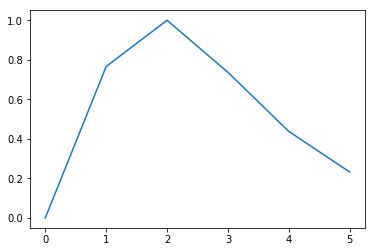

In [9]:
# HRF functions for simulating the HRF effect in fMRI data
from scipy.stats import gamma
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 2.5)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times,2)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values)

TR =1
tr_times = np.arange(0, 6, TR)
hrf_at_trs = hrf(tr_times)
plt.plot(tr_times, hrf_at_trs)

In [10]:
def HRF_convolve(H):
    s_it=[]
    for s in range(n_sbj):
        l_it=[]
        for l in range(3):
            R=[]
            for v in range(seq_len):
                convolved = np.convolve(H[s,l,:,v], hrf_at_trs)
                n_to_remove = len(hrf_at_trs) - 1
                convolved = convolved[:-n_to_remove]
                R.append(convolved)
            l_it.append(R)
        s_it.append(l_it)
    s_it=np.swapaxes(s_it,2,3)
    return s_it

In [11]:
H_p_all=HRF_convolve(H_p_all)
H_i_all=HRF_convolve(H_i_all)

In [12]:
H_p_all=np.asarray(H_p_all)
H_i_all=np.asarray(H_i_all)

In [13]:
#reorder function for BA-CA ISPC analysis(neural alignment for same inputs with different context)
def BA_CA_reorder(seq_int,seq_scram,H_int,H_scram, filler):
    us_H = []
    int_H = []
    zipped=zip(seq_scram,H_scram)
    zipped_int=zip(seq_int,H_int)
    zipped=list(zipped)
    zipped_int=list(zipped_int)
    zipped_removed=list(filter(lambda a: a[0] != 1000, zipped))
    zipped_removed_int=list(filter(lambda a: a[0] != 1000 and a[0] != 100, zipped_int))
    for k in range(len(zipped_removed_int)):
        int_H.append(zipped_removed_int[k][1])
    if filler==True:
        for i in range(len(zipped_removed)):
            if zipped_removed[i-1][0]==100 and zipped_removed[i][0]!=100:
                zipped_sorted=sorted(zipped_removed[i:i+seq_len],key = lambda t: t[0])
                for j in range(seq_len):
                    us_H.append(zipped_sorted[j][1])
    if filler==False:
        for i in range(0,len(zipped_removed),seq_len):
            zipped_sorted=sorted(zipped_removed[i:i+seq_len],key = lambda t: t[0])
            for j in range(seq_len):
                    us_H.append(zipped_sorted[j][1])
                
    return int_H,us_H

In [14]:
#reorder function for AB-AC ISPC analysis(neural separation for different inputs with same context)
def AB_AC_reorder(seq_scram,seq_int,H_scram,H_int,para_int, para_scram,seq_len,para_len):

    a=[list(a) for a in zip(seq_scram,H_scram)]
    b=[list(a) for a in zip(seq_int,H_int)]
    filler=[]
    for i in range(len(a)):
        if a[i][0]==100:
            filler.append(i)
            
    zipped = [i for j, i in enumerate(a) if j not in filler]
    zipped_int=[i for j, i in enumerate(b) if j not in filler]
    ss = [i for j, i in enumerate (seq_scram) if j not in filler]
    si = [i for j, i in enumerate (seq_int) if j not in filler]
        
    para_num=int(seq_len/para_len)
    new_zipped_int=[]
    new_zipped=[]

    for i in range(0,len(para_scram)):
        re = i%para_num
        if para_scram[i]!=para_num-1 and re!=para_num-1 and ss[para_len*(i)]+para_len!=ss[para_len*(i+1)]:
            new_zipped_int.append(zipped_int[para_len*(para_scram[i]+1):para_len*(para_scram[i]+1)+para_len])
            new_zipped.append(zipped[para_len*(i+1):para_len*(i+1)+para_len])

    int_new_H=[]
    for i in range(len(new_zipped_int)):
        for j in range(len(new_zipped_int[0])):
            int_new_H.append(new_zipped_int[i][j][1])
            
    scram_H=[]
    for i in range(len(new_zipped)):
        for j in range(len(new_zipped[0])):
            scram_H.append(new_zipped[i][j][1])

    
    return scram_H,int_new_H

In [18]:
#ISPC analysis

def ISPC(it_data, uls_data,seg_length): #start and end time within events
    n,time,voxel=np.shape(it_data)
    ind=np.arange(n)
    r_pc_rII,r_pc_rUU,r_pc_rUI,r_pc_rIU=([]for i in range(4)) 
    for s in range(n):
        a = ind[np.arange(len(ind))!= s]
        r_seg_rII,r_seg_rUU,r_seg_rUI,r_seg_rIU=([]for i in range(4)) 
        
        for t in range(0,time,seg_length):
            r=[]
            for i in range(seg_length):
                other_rII = np.mean(it_data[a,t+i,:],0)
                r.append(np.corrcoef(other_rII,it_data[s,t+i,:])[0][1])
            r_seg_rII.append(r)
            r=[]
            for i in range(seg_length):
                other_rUU = np.mean(uls_data[a,t+i,:],0)
                r.append(np.corrcoef(other_rUU,uls_data[s,t+i,:])[0][1])
            r_seg_rUU.append(r)
            r=[]
            for i in range(seg_length):
                other_rUI = np.mean(it_data[:,t+i,:],0)
                r.append(np.corrcoef(other_rUI,uls_data[s,t+i,:])[0][1])
            r_seg_rUI.append(r)
            r=[]
            for i in range(seg_length):
                other_rIU = np.mean(uls_data[:,t+i,:],0)
                r.append(np.corrcoef(other_rIU,it_data[s,t+i,:])[0][1])
            r_seg_rIU.append(r)
        r_pc_rII.append(r_seg_rII)
        r_pc_rUU.append(r_seg_rUU)
        r_pc_rUI.append(r_seg_rUI)
        r_pc_rIU.append(r_seg_rIU)
    rII = np.mean(r_pc_rII,0)
    rUU = np.mean(r_pc_rUU,0)
    rUI = np.mean(r_pc_rUI,0)
    rIU = np.mean(r_pc_rIU,0)
    
    return rII, rUU, rUI, rIU

In [15]:
# cutting off the first two elements since the meaningful hidden units in layer 2&3 starts at time=3
test_p_seq=test_scram_seq[2:]
test_i_seq=test_int_seq[2:]

In [16]:
#reordering process for AB-AC ISPC analysis
scram_all = []
int_new_all = []

for s in range(n_sbj):
    us_l=[]
    int_l=[]
    for l in range(3):
        scram_H,int_new_H= AB_AC_reorder(test_p_seq,test_i_seq,H_p_all[s,l,:,:],H_i_all[s,l,:,:],para_int,para_scram,seq_len,para_len)
        us_l.append(scram_H)
        int_l.append(int_new_H)
    scram_all.append(us_l)
    int_new_all.append(int_l)
scram_all=np.asarray(scram_all)
int_new_all=np.asarray(int_new_all)

In [19]:
def CI(alpha, data):
    CI=stats.norm.interval(alpha, loc=np.mean(data), scale=stats.sem(data))
    
    return (CI[1]-CI[0])/2

In [20]:
rII1,rSS1,rSI1,_=ISPC(int_H_all[:,0,:,:],us_H_all[:,0,:,:],para_len)
rII2,rSS2,rSI2,_=ISPC(int_H_all[:,1,:,:],us_H_all[:,1,:,:],para_len)
rII3,rSS3,rSI3,_=ISPC(int_H_all[:,2,:,:],us_H_all[:,2,:,:],para_len)

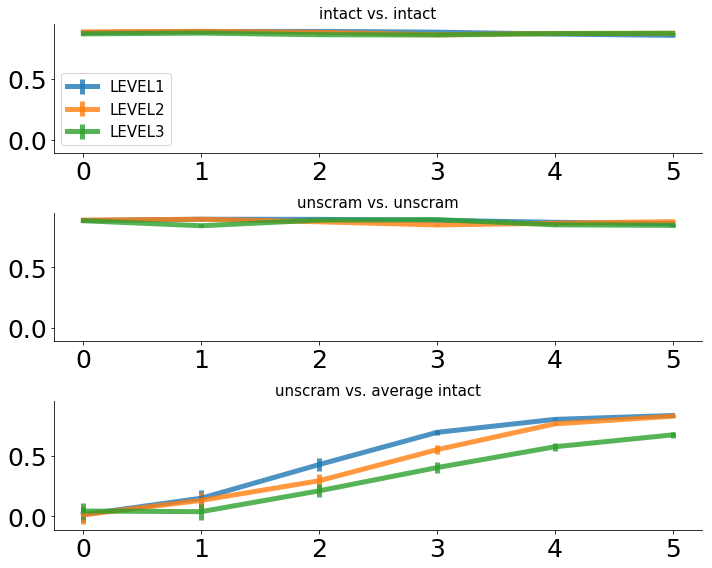

In [33]:
#visualize the construction curves
f, ax = plt.subplots(3, 1, sharey=True,figsize=(10,8))
length=para_len
ax[0].set_title("intact vs. intact", fontsize=15)
ax[0].errorbar(np.arange(length), np.mean(rII1,0)[:length], yerr=CI(0.95,rII1)[:length], label='LEVEL1',linewidth=5, alpha=0.8)
ax[0].errorbar(np.arange(length),np.mean(rII2,0)[:length], yerr=CI(0.95,rII2)[:length], label='LEVEL2',linewidth=5, alpha=0.8)
ax[0].errorbar(np.arange(length),np.mean(rII3,0)[:length], yerr=CI(0.95,rII3)[:length], label='LEVEL3',linewidth=5, alpha=0.8)
ax[0].legend(fontsize=15)
ax[1].set_title("unscram vs. unscram", fontsize=15)
ax[1].errorbar(np.arange(length), np.mean(rSS1,0)[:length], yerr=CI(0.95,rSS1)[:length], label='LEVEL1',linewidth=5, alpha=0.8)
ax[1].errorbar(np.arange(length),np.mean(rSS2,0)[:length], yerr=CI(0.95,rSS2)[:length], label='LEVEL2',linewidth=5, alpha=0.8)
ax[1].errorbar(np.arange(length),np.mean(rSS3,0)[:length], yerr=CI(0.95,rSS3)[:length], label='LEVEL3',linewidth=5, alpha=0.8)
ax[2].set_title("unscram vs. average intact", fontsize=15)
ax[2].errorbar(np.arange(length), np.mean(rSI1,0)[:length], yerr=CI(0.95,rSI1)[:length], label='LEVEL1',linewidth=5, alpha=0.8)
ax[2].errorbar(np.arange(length),np.mean(rSI2,0)[:length], yerr=CI(0.95,rSI2)[:length], label='LEVEL2',linewidth=5, alpha=0.8)
ax[2].errorbar(np.arange(length),np.mean(rSI3,0)[:length], yerr=CI(0.95,rSI3)[:length], label='LEVEL3',linewidth=5, alpha=0.8)

for i in range(3):
#     ax[i].legend(fontsize=10)
    ax[i].tick_params(labelsize=25)
    ax[i].set_yticks(np.arange(0,1,0.5))
    ax[i].set_xticks(np.arange(0,length))
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

plt.tight_layout()

plt.show()

In [17]:
#reordering process for BA-CA ISPC analysis
int_H_all = []
us_H_all = []
for s in range(n_sbj):
    us_l=[]
    int_l=[]
    for l in range(3):
        int_H,us_H= BA_CA_reorder(test_i_seq,test_p_seq,H_i_all[s,l,:,:],H_p_all[s,l,:,:],True)
        us_l.append(int_H)
        int_l.append(us_H)
    int_H_all.append(us_l)
    us_H_all.append(int_l)
int_H_all=np.asarray(int_H_all)
us_H_all=np.asarray(us_H_all)

In [22]:
rII1_ABAC,rSS1_ABAC,rSI1_ABAC,_=ISPC(scram_all[:,0,:,:],int_new_all[:,0,:,:],para_len)
rII2_ABAC,rSS2_ABAC,rSI2_ABAC,_=ISPC(scram_all[:,1,:,:],int_new_all[:,1,:,:],para_len)
rII3_ABAC,rSS3_ABAC,rSI3_ABAC,_=ISPC(scram_all[:,2,:,:],int_new_all[:,2,:,:],para_len)

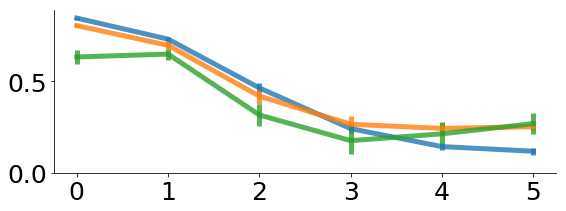

In [24]:
#visualize the forgetting curves
plt.figure(figsize=(9,3))
length=para_len
plt.errorbar(np.arange(length), np.mean(rSI1_ABAC,0)[:length], yerr=CI(0.95,rSI1_ABAC)[:length], label='LEVEL1',linewidth=5, alpha=0.8)
plt.errorbar(np.arange(length),np.mean(rSI2_ABAC,0)[:length], yerr=CI(0.95,rSI2_ABAC)[:length], label='LEVEL2',linewidth=5, alpha=0.8)
plt.errorbar(np.arange(length),np.mean(rSI3_ABAC,0)[:length], yerr=CI(0.95,rSI3_ABAC)[:length], label='LEVEL3',linewidth=5, alpha=0.8)

ax=plt.gca()
# ax.legend(fontsize=10)
ax.tick_params(labelsize=25)
ax.set_yticks(np.arange(0,1,0.5))
ax.set_xticks(np.arange(0,length))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

